# Prototypical Network做人臉分類
## Metric base
* 將data embed到一個高維空間中
* 同種類距離短，不同種類距離長
* 比較種類參考資料(support)和待測資料(query)間的距離就能預測待測資料屬於哪個種類
* Siamese每次比較常常需要輸入每種類完整support資料(總共有1000種類，每種K筆就要比較1000*K次)，才能做預測，佔MEM、花時間

## Prototype
* 訓練目標: N種類比較出哪類最近
    * N個種類每個種類只以support在高維空間中的典型(prototype)來做為比較距離對象
* 意義: 
    * 比較次數可以除以N(總共有1000種類，每種K筆，要比較1000/N次)
    * prototype也可以先存起來，節省更多時間
* 結構: 
    * 如下圖所示，假設embedding function已經訓練好，那樣預先丟入三種類的source：獅子、貓跟老鼠，以高維重心估計出三個種類的prototype。
    * 再把query丟到embedding function中，就可以計算和三個prototype間的距離，因為與貓的prototype距離最短，所以判斷是貓。


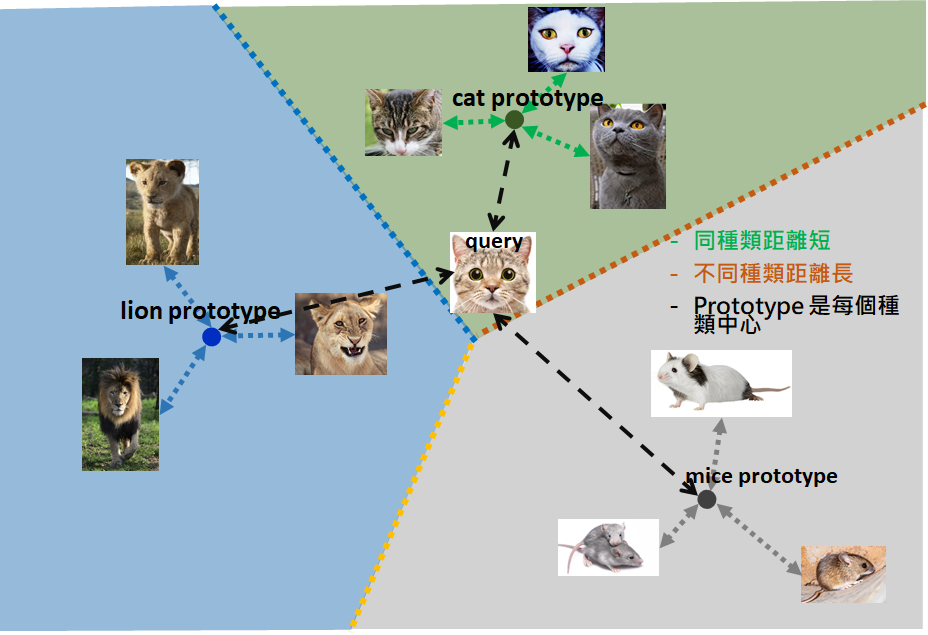

* 訓練方式: 距離相反的Softmax取Categorical cross entropy
* 使用方式: 
    * 每次比較會是N種類每種類K筆資料在latent space形成prototype
    * 與query經過embedding之後的latent做比較預測哪與哪個prototype最近
    * 如果總共有1000種類，每種K筆，要比較1000/N次
    * prototype也可以先存起來，節省更多時間

# 範例內容
這次的資料集與Siames Network範例中的資料集一樣是使用[AT & T's the Database of Faces](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)做人臉辨識範例，40個人每人共有10張不同角度的照片。

我們這次的任務是希望network學會只依照片來辨別人臉屬於哪個人：

選出5個不同人的照片各三張，並從這五個人的照片中再抽出一張，network必須辨識這一張屬於哪個人。

**程式碼部分會做以下部分：**
* Data Loader
* 資料抽樣、切分
* 建立模型
* 模型訓練
* 預測結果

# Data Loader
* (meta)batch: 一次訓練BATCH_SIZE個task
* task: 選5人不重複
* support: 5人資料中從每人10張選3張當support
* query: 5人資料中再選1張當query(不重複選取)

In [ ]:
# Colab上的話要下載資料
# !gdown https://drive.google.com/u/1/uc?id=1sSAsIVQl4u_eMWw4t9dfD3gGnHKwAUhz&export=download
# !unzip orl_faces.zip
# !mkdir data
# !mv orl_faces/ data

In [3]:
'''Toolboxs'''
import re
import cv2
import os
from os.path import join
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
'''Tensorflow'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks as cb
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
if len(gpus)>1:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{len(gpus)-1}"

先設定讀取圖片程式，這個資料集圖檔讀取方式需自訂，要輸入圖片的和寬、高、最大值，其中header是圖檔的標頭，讀取時要略過

圖片路徑為{orl_faces資料夾}/s1到s40

每個subject的圖片放在不同資料夾

In [4]:
W,H,CH = 64,64,1
'''pgm檔讀取程式'''
def read_pgm(filename):
    byteorder='>'
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
'''完整影像讀取程式，含pre-process'''
def load_img(path, width = W):
    '''讀出來並從0~255縮到0~1間'''
    img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    '''依照比較短的邊為指定長度，長的那邊只剪下中間指定長度的距離'''
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2
    center_square = np.array([width,width])// 2
    new_size=(width,width)
    
    '''Cropping + resize'''
    img = img[oh:oh + shape_dst, ow:ow + shape_dst]
    img=np.expand_dims(cv2.resize(img, new_size),-1) # for tensorflow cnn
    return tf.constant(img)
SUFFIX='.pgm'


這次要做5 way 3 shot的data loader，且support中每個class都抽一個query

* support: BATCH_SIZE x (5 x 3) x 長 x 寬 x 顏色頻道(1)
* query: BATCH_SIZE x 5 x 長 x 寬 x 顏色頻道(1)

會先load in set中的的各種class排列組合 shuffle一次

再來每個meta batch依照batch size抽取數個排列組合

接著依照順序5人中每人抽3張丟進support的位置中，再每人抽一張丟進query的位置中
support set的label為被抽到的順序，依序是0,1,2,3,4
query set的label就照著support去配置，看抽到的是前面support中的第幾個人就是幾號，採one hot encoding

最後support和query並再一起丟給model

In [5]:
WAYS = 5
SHOTS=3
QUERIES=WAYS*1
BATCH_SIZE=8

首先列出sourse跟target有哪些classes

In [6]:
np.random.seed(2021)
tf.random.set_seed(2021)

# DATA_ROOT=join("..","..","data")
DATA_ROOT="I:\AIA Small Data\datasets"
all_classes = glob(join(DATA_ROOT,"orl_faces","*"))
source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

total 40 classes=source 32 + target 8 classes


篩掉圖片數不滿足的人

In [7]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

In [8]:
## exclude classes with too few examples
source_classes=[sdir for sdir in source_classes if len(glob(join(sdir,'*'+SUFFIX)))>SHOTS+QUERIES]

sorce_len=len(source_classes)
print(f"source {sorce_len} + target {target_len} classes")

source 32 + target 8 classes


In [9]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

建立每個人的loader，隨意從每個人的圖片中抽取 (尚未指定張數)

In [10]:
'''Mapping function for loading'''
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source set中每個人都有一個tf Dataset loader'''
source_sub = [
    tf.data.Dataset.list_files(join(sc,'*'+SUFFIX), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
'''Target set中每個人都有一個tf Dataset loader'''
target_sub = [
    tf.data.Dataset.list_files(join(sc,'*'+SUFFIX), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]

建立每個task的loader，隨意從WAY個人抽取SHOT張，並再隨機指派每個way的class是從0~WAY-1的哪一個

In [26]:
def gen(all_sub):
    '''先決定好順序'''
    order=np.random.permutation(len(all_sub))  
    '''For each task'''
    for tasks in range(len(all_sub)//WAYS):
        '''從已決定好的順序拉出WAY個人'''
        picked=[all_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        '''support每個人各有SHOTS張照片'''
        support = tf.concat(
            [
                next(
                    iter(
                        sub.batch(SHOTS)
                    )
                    ) for sub in picked
            ]
            , axis=0)
        '''query挑WAY人中的QUERY張，這邊是設定每張屬於不同人，順序不固定'''
        idxs=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
            [
                next(
                    iter(
                        picked[idx].batch(1)
                    )
                    ) for idx in idxs
            ]
            , axis=0)
        '''輸出的時候把support跟query接在一起'''
        yield tf.concat([support, query], axis=0), tf.stack([keras.utils.to_categorical(idx,num_classes=WAYS) for idx in idxs], axis=0)

建立data generator，可以一次抽一個meta batch的資料
1. 要input一個function(這邊用partial產生一個預先設定好參數的function)
1. output types要對好前面的格式
2. output shape要給對

In [32]:
MLUT=16
data_source = tf.data.Dataset.from_generator(partial(gen,source_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).prefetch(BATCH_SIZE).repeat(MLUT).shuffle(buffer_size=999).cache().batch(BATCH_SIZE)
data_target = tf.data.Dataset.from_generator(partial(gen,target_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).repeat(MLUT*4).batch(BATCH_SIZE)

可以看一下每次sample出來的東西
* X:共BATCH_SIZE個meta batch,有WAYS*SHOTS+QUERIES個圖，每個圖WxHxCH大小
* y:共QUERIES個答案

In [33]:
for source_x,source_y in data_source:
    break

Support 0


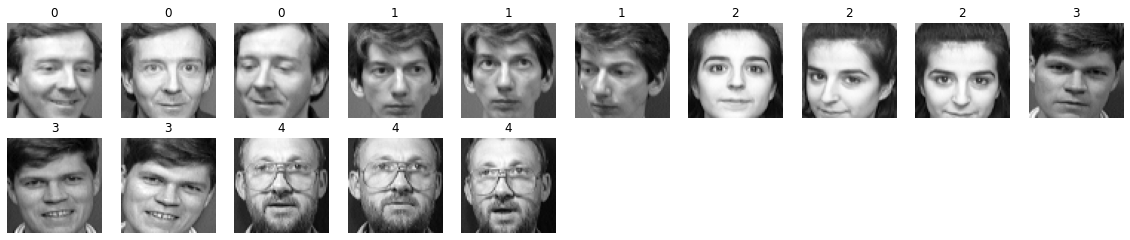

Query 0


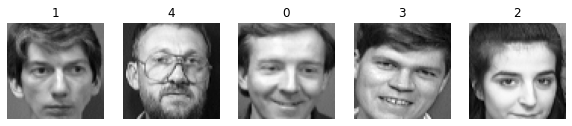

In [34]:
plt.figure(figsize=(20,6));ee=1
batch=0
print(f"Support 0")
for jj in range(WAYS*SHOTS):
    plt.subplot(SHOTS,WAYS*2,ee);plt.imshow(source_x[batch,jj,...,0],"gray")
    plt.title(f"{jj//SHOTS}");plt.axis("off");ee+=1
plt.show()
print("Query 0");plt.figure(figsize=(10,2));ee=1
for jj in range(QUERIES):
    plt.subplot(1,QUERIES,ee);plt.imshow(source_x[batch,WAYS*SHOTS+jj,...,0],"gray")
    plt.title(f"{source_y[batch,jj].numpy().argmax(-1)}");plt.axis("off");ee+=1
plt.show()

In [15]:
print(source_x.shape,source_x.numpy().min(),source_x.numpy().max())
print(source_y.shape,source_y.numpy().min(),source_y.numpy().max())
print(source_y.numpy().argmax(-1))

(8, 20, 64, 64, 1) 0.009888173 0.9397863
(8, 5, 5) 0.0 1.0
[[0 4 2 3 1]
 [1 3 0 4 2]
 [2 0 4 1 3]
 [1 0 4 3 2]
 [3 0 4 2 1]
 [4 1 0 3 2]
 [2 1 4 0 3]
 [4 1 0 2 3]]


In [16]:
for target_x,target_y in data_target:
    break
print(target_x.shape,target_x.numpy().min(),target_x.numpy().max())
print(target_y.shape,target_y.numpy().min(),target_y.numpy().max())
print(target_y.numpy().argmax(-1))

(8, 20, 64, 64, 1) 0.009263938 0.912366
(8, 5, 5) 0.0 1.0
[[3 4 1 0 2]
 [4 3 0 2 1]
 [2 0 3 4 1]
 [2 0 1 3 4]
 [2 4 0 3 1]
 [3 2 1 0 4]
 [0 2 1 4 3]
 [3 4 2 1 0]]


# 建立模型
按圖索驥，開始組裝network，會有embedding用的encoder，並且先寫好計算高維距離用的distance function。

In [28]:
# Embedding function
def conv_net(input_shape):
    convnet = Sequential()
    for i in range(4):
        convnet.add(Conv2D(64,(3,3),padding='valid',input_shape=input_shape))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    return convnet
def euclidean_distance(f_1,f_2):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(f_1 - f_2), axis=-1))


把support和query資料一個個丟到encoder中計算feature。
1. 每個類型平均起來計算prototype。
2. 每個query再把和每個class prototype的distnace算出。
3. 最後使用負distance的softmax判定到底屬於哪個class

In [35]:
base_dim = (W,H,CH)
base_network = conv_net(base_dim)
# Query feature
x_in=Input(shape=(WAYS*SHOTS+QUERIES,W,H,CH))
latent_s=[base_network(x_in[:,ii]) for ii in range(WAYS*SHOTS)]
latent_q=[base_network(x_in[:,WAYS*SHOTS+ii]) for ii in range(QUERIES)]

y=list()
for qq in range(QUERIES):
    dist_scores=list()
    for ww in range(WAYS):
        latent_proto=tf.reduce_mean(tf.stack(latent_s[ww*SHOTS:(ww+1)*SHOTS],axis=-1),axis=-1)
        dist_avg=euclidean_distance(latent_q[qq],latent_proto)
        dist_scores.append(dist_avg)
    y.append(tf.nn.softmax(-tf.stack(dist_scores,axis=-1),axis=-1))
y=tf.stack(y,axis=1)
    
model = Model(inputs=x_in, outputs=y)

使用categorical cross entropy作為loss function，Adam optimizer來compile model

In [36]:
lr=0.001
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=1e-8, verbose=1)
tensorboard = cb.TensorBoard(log_dir="tf_proto_logs")
earlystop=cb.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True, verbose=1)
opt = tf.keras.optimizers.Adam(lr=lr)
model.compile(loss=CategoricalCrossentropy(), optimizer=opt, metrics=['acc'])

# 模型訓練
訓練使用10 epoch、batch size為2個tasks，
在訓練時再使用validation split驗證loss是否下降，或者只是over fitting。

In [37]:
EPOCHS=400
# %%time
try:
    model.fit(data_source,
              epochs=EPOCHS, 
              verbose=1,workers=4, 
              callbacks=[reduce_lr,earlystop, tensorboard],
              validation_data=data_source)
except KeyboardInterrupt:
    print("KeyboardInterrupt")

Epoch 1/400
      2/Unknown - 2s 770ms/step - loss: 0.2543 - acc: 0.9375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0475s vs `on_train_batch_end` time: 1.4932s). Check your callbacks.
12/12 [==============================] - 3s 281ms/step - loss: 0.1790 - acc: 0.9500 - val_loss: 1.1008 - val_acc: 0.9208
Epoch 2/400
12/12 [==============================] - 1s 53ms/step - loss: 0.0476 - acc: 0.9937 - val_loss: 0.4399 - val_acc: 0.9792
Epoch 3/400
12/12 [==============================] - 1s 54ms/step - loss: 0.0194 - acc: 1.0000 - val_loss: 0.0233 - val_acc: 1.0000
Epoch 4/400
12/12 [==============================] - 1s 53ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 5/400
12/12 [==============================] - 1s 54ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 6/400
12/12 [==============================] - 1s 54ms/step - loss: 0.0056 - acc: 1.0000 - val_los

# 結果
其結果學蠻快的，但有overfit的可能(不太容易適應差太多的dataset)

更詳細的network performance可以參考paper with code排名

In [38]:
model.evaluate(data_target, verbose=2)

8/8 - 28s - loss: 0.0589 - acc: 0.9875


[0.05890481173992157, 0.987500011920929]

# Exercise
請各位使用Siamese訓練比較Omniglot資料集的兩個字是否相同:

Omniglot資料集：
* source有3856個來自不同語言的不同字符，target有659個不同字符
* 每個class有20張不同人手寫的同一個文字的圖片
* task: source字符選5種不重複
* support: 5字符中從每種20張照片選3張當support
* query: 5字符中再各選1張照片當query(不重複選取，亂序)

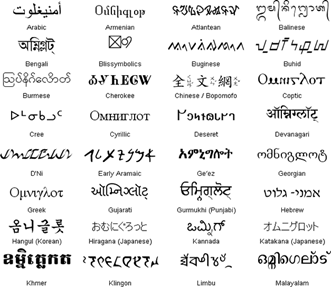

**以下附上圖案讀取的code**

In [ ]:
import numpy as np
import cv2

W,H,CH = 64,64,1

def read_image(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.png'


請自行撰寫data loader以及training內容

e.g.
```
# Data loader
def gen(...):
    ...
    return X,y

# 建立模型
...
model = Model(x,y)

# 模型訓練
...
model.fit(data_source,......,validation_data=data_source)
```

# References
[git](https://github.com/sudharsan13296/Hands-On-Meta-Learning-With-Python)

[Paper](https://arxiv.org/abs/1703.05175)